# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Reading the data from SQLITE
1. We are going to classify our data using the attribute "SCORE" from our dataframe
2. SCORE > 3 is classified as Positive review, SCORE < 3 is classified as Negative review
3. Since SCORE = 3 is Neutral, we will not consider those reviews in our classiication

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Data Cleaning: Removing miscategorized data points

1. The products "B00004CI84" and "B00004CXX9" belong to movie category. Since the product name contains the word "Juice", it has been miscategorized under food.

2. "B0002YW26E" is a Pest control product. Miscategorized as food.

3. The products "6641040" and "2841233731" are CookBooks.

In [14]:
# Removing the miscategorized products from the data

final_data=final[~final.ProductId.isin (['B0002YW26E','B00004CI84','B00004CXX9','6641040','2841233731'])]
print("Number of final points in our data",final_data.shape)

Number of final points in our data (363896, 10)


In [15]:
#How many positive and negative reviews are present in our dataset?
print(final_data['Score'].value_counts())

1    306829
0     57067
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_238 = final_data['Text'].values[238]
print(sent_238)
print("*"*100)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_238 = re.sub(r"http\S+", "", sent_238)
print(sent_238)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

print(sent_238)
print("*"*100)
soup = BeautifulSoup(sent_238, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_79290 = final_data['Text'].values[79290]
print(sent_79290)
print("*"*100)
sent_79290 = decontracted(sent_79290)
print(sent_79290)

I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can't find them.
****************************************************************************************************
I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can not find them.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
print(text)
print("*"*100)
text = re.sub("\S*\d\S*", "", text).strip()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text = re.sub('[^A-Za-z0-9]+', ' ', text)
print(text)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 363896/363896 [02:25<00:00, 2505.54it/s]


In [24]:
preprocessed_reviews[1600]

'cats love product not worry clay getting digested cats family matter one cats getting sick clay tried since natural voila healthy kitties sure may not work new fangled litter boxes not think made scoop litter must sit probably min stay ball love counts plus price awesome usually travel half hours get shipping worth gas travel time thank'

In [25]:
final_data['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of review
print(final_data['CleanedText'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder


In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|██████████| 363896/363896 [01:34<00:00, 3858.80it/s]


In [27]:
print(final_data['Summary'].values[101])
print("*"*100)
print(preprocessed_summary[101])

My dog would do anything for this treat
****************************************************************************************************
dog would anything treat


In [28]:
final_data['CleanedSummary']=preprocessed_summary #adding a column of CleanedText which displays the data after pre-processing of summary review
print(final_data['CleanedSummary'].values[201])

delicious mildly sweet cookie


In [29]:
final_data['FinalReview']= final_data['CleanedText'] + str(" ") + final_data['CleanedSummary']
print(final_data['CleanedText'].values[100])
print(final_data['CleanedSummary'].values[100])
print("*"*100)
print(final_data['FinalReview'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder
good quality
****************************************************************************************************
purchased several different brands liver treats best terms good size pieces small bits little powder good quality


In [30]:
final_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'CleanedSummary', 'FinalReview'],
      dtype='object')

# [4] Applying Logistic Regression

In [30]:
# Taking 200k points from our dataset

final_sample = final_data.sample(n=200000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(200000, 13)
(200000,)


In [32]:
word_count= []
for sentence in final_sample['FinalReview'].values:
    total_words= len(sentence.split())
    word_count.append(total_words)
    
print(final_sample['FinalReview'].values[12])
print("The number of words in the above review is: ", word_count[12])

purchased product additive punch wedding boiled minutes recommended perfect putting punch not sweeten delicious would absolutely recommend product others worked great
The number of words in the above review is:  21


In [33]:
final_sample['word_count']=word_count 
print(final_sample['FinalReview'].values[5])
print("*"*100)
print(final_sample['word_count'].values[5])

definetely highest quality green tea ever love bags surprised good costco tea drinking couple years love high quality green tea
****************************************************************************************************
20


In [34]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
112219    1351209600
Name: Time, dtype: int64


In [35]:
import sklearn.model_selection as model_selection
from sklearn.neighbors import KNeighborsClassifier

# split the data set into train and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in test dataset", X_test.shape)
print(y_tr.value_counts())

No of data points in training dataset (160000, 14)
No of data points in test dataset (40000, 14)
1    135647
0     24353
Name: Score, dtype: int64


In [55]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
345345    1337040000
Name: Time, dtype: int64
********************************
358642    1337040000
Name: Time, dtype: int64
112219    1351209600
Name: Time, dtype: int64


## [4.1] Logistic Regression on BOW

In [37]:
#BoW: 
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_counts_train = count_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train = hstack((final_counts_train,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train.get_shape())

The shape of train text BOW vectorizer  (160000, 2319414)
The shape of train text BOW after adding word_count  (160000, 2319415)


In [38]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler(with_mean=False).fit_transform(final_train)

In [39]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({0: 135647, 1: 135647})


In [40]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 24353), (1, 135647)]
Train data after upsampling :  [(0, 135647), (1, 135647)]


In [41]:
#BoW: 
final_counts_test = count_vect.transform(X_test['FinalReview'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test = hstack((final_counts_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_bow = StandardScaler(with_mean=False).fit_transform(final_test)

The shape of test text BOW vectorizer  (40000, 2319414)
The shape of train text BOW after adding word_count  (40000, 2319415)


### [4.1.1] Applying Logistic Regression with L1 regularization on BOW

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.9999999999728263
Test Accuracy: 0.9444243019339041


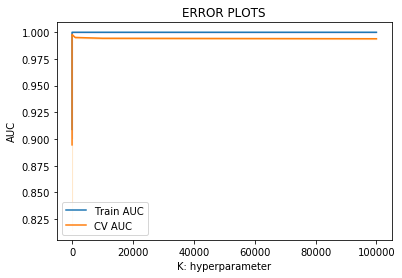

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l1',n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_bow, y_train_bow)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_bow,y_train_bow))
print("Test Accuracy:",clf.score(X_test_bow,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 10}
AUC score on train data:  0.9999999999184788
AUC score on test data:  0.9457064098187755


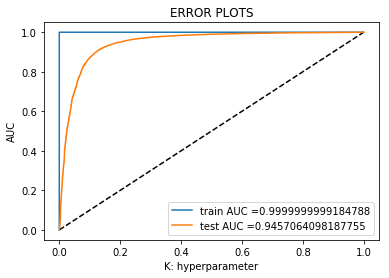

Train confusion matrix
[[135647      0]
 [     1 135646]]
Test confusion matrix
[[ 5095  1758]
 [ 1096 32051]]


In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l1', n_jobs= -1)
LR.fit(X_train_bow, y_train_bow)

y_pred_proba_train = LR.predict_proba(X_train_bow)[:,1]
y_pred_proba_test = LR.predict_proba(X_test_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_bow, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, LR.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(X_test_bow)))

Confusion matrix for TRAIN data


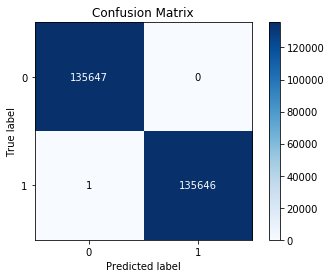

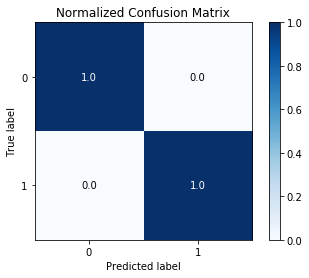

In [44]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, LR.predict(X_train_bow))
skplt.metrics.plot_confusion_matrix(y_train_bow, LR.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


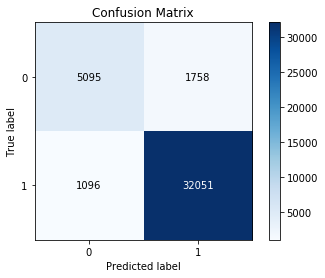

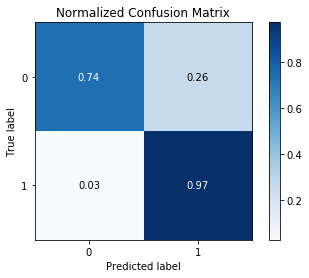

In [45]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_bow))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_bow), normalize=True)

#### [4.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [47]:
# Calculating sparsity on weight vector
import numpy as np

LR = LogisticRegression(C=optimal_C, penalty='l1');
LR.fit(X_train_bow, y_train_bow)
w = LR.coef_
print("Sparsity on weight vector obtained using L1 regularization on BOW is: ",np.count_nonzero(w))

Sparsity on weight vector obtained using L1 regularization on BOW is:  406952


### [4.1.2] Applying Logistic Regression with L2 regularization on BOW

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Training Accuracy: 0.9999999951902458
Test Accuracy: 0.9237748675096709


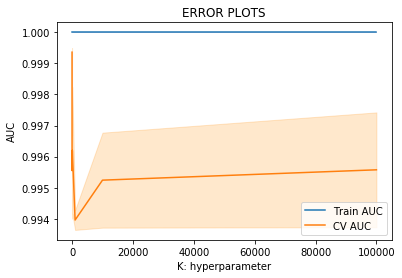

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l2',n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_bow, y_train_bow)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_bow,y_train_bow))
print("Test Accuracy:",clf.score(X_test_bow,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.0001}
AUC score on train data:  0.9999999951902458
AUC score on test data:  0.9237748675096709


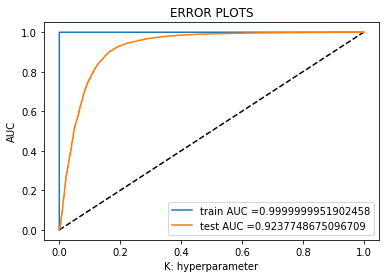

Train confusion matrix
[[135647      0]
 [    37 135610]]
Test confusion matrix
[[ 4228  2625]
 [  550 32597]]


In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LR.fit(X_train_bow, y_train_bow)

y_pred_proba_train = LR.predict_proba(X_train_bow)[:,1]
y_pred_proba_test = LR.predict_proba(X_test_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_bow, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, LR.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(X_test_bow)))

Confusion matrix for TRAIN data


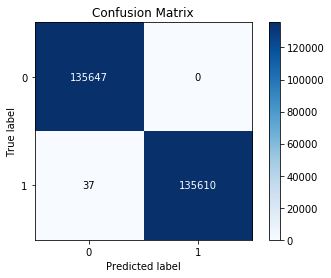

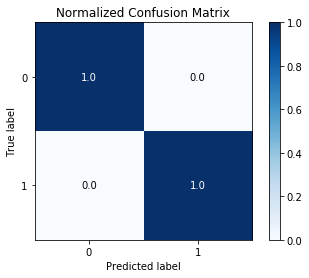

In [50]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, LR.predict(X_train_bow))
skplt.metrics.plot_confusion_matrix(y_train_bow, LR.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


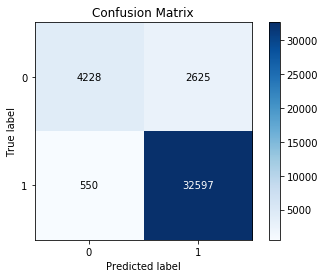

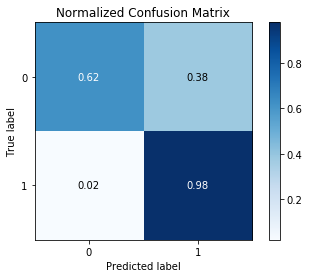

In [51]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_bow))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_bow), normalize=True)

### [4.1.3] Feature Importance on BOW 

In [53]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(count_vect, LR)

The informative features are below: 
	-0.4050	disappointed   			0.1163	great          
	-0.2903	expensive      			0.0799	love           
	-0.2809	fat            			0.0764	good           
	-0.2791	salty          			0.0737	best           
	-0.0442	beware         			0.0612	delicious      
	-0.0394	not good       			0.0506	excellent      
	-0.0392	not worth      			0.0450	loves          
	-0.0379	not expected   			0.0437	favorite       
	-0.0369	not buy        			0.0419	yummy          
	-0.0320	awful          			0.0411	tasty          


## [4.2] Logistic Regression on TFIDF

In [31]:
# Taking 200k points from our dataset

final_sample = final_data.sample(n=100000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(100000, 13)
(100000,)


In [32]:
word_count= []
for sentence in final_sample['FinalReview'].values:
    total_words= len(sentence.split())
    word_count.append(total_words)
    
print(final_sample['FinalReview'].values[12])
print("The number of words in the above review is: ", word_count[12])

tiny mighty popcorn tbm best popcorn ever adventurous tried sorts popcorn kettle corn cheddar butter sugar even marshmallow popcorn experience popcorn world truthfully say always come back tbm popcorn healthy popcorn market even taste better every single microwave variety eating tbm popcorn years recently totally redesigned bag tiny popcorn comes wow looks classy elegant sophisticated even gives guide lines prepare product best results popping not mention little history ancient heirloom popcorn well done tbm popcorn well done avid popcorn lover cannot wait see next big move keep good work farmer gene great quality popcorn
The number of words in the above review is:  94


In [33]:
final_sample['word_count']=word_count 
print(final_sample['FinalReview'].values[5])
print("*"*100)
print(final_sample['word_count'].values[5])

great price one favorite teas wish irish breakfast good buy english breakfast twinings tea
****************************************************************************************************
14


In [34]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

1146    961718400
Name: Time, dtype: int64
489266    1351209600
Name: Time, dtype: int64


In [35]:
import sklearn.model_selection as model_selection
from sklearn.neighbors import KNeighborsClassifier

# split the data set into train and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in test dataset", X_test.shape)
print(y_tr.value_counts())

No of data points in training dataset (80000, 14)
No of data points in test dataset (20000, 14)
1    67849
0    12151
Name: Score, dtype: int64


In [36]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

1146    961718400
Name: Time, dtype: int64
490299    1337126400
Name: Time, dtype: int64
********************************
252501    1337126400
Name: Time, dtype: int64
489266    1351209600
Name: Time, dtype: int64


In [37]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train_tfidf = hstack((tf_idf_tr,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train_tfidf.get_shape())

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
x_scaled_tr = StandardScaler(with_mean=False).fit_transform(final_train_tfidf)

The shape of train TFIDF vectorizer  (80000, 1331703)
The shape of train text BOW after adding word_count  (80000, 1331704)


In [38]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(x_scaled_tr, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 67756, 1: 67756})


In [39]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 12244), (1, 67756)]
Train data after upsampling :  [(0, 67756), (1, 67756)]


In [40]:
tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test_tfidf = hstack((tf_idf_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test_tfidf.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_tfidf = StandardScaler(with_mean=False).fit_transform(final_test_tfidf)

The shape of test TFIDF vectorizer  (20000, 1331703)
The shape of train text BOW after adding word_count  (20000, 1331704)


### [4.2.1] Applying Logistic Regression with L1 regularization on TFIDF 

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.9999931174348439
Test Accuracy: 0.9532547890103552


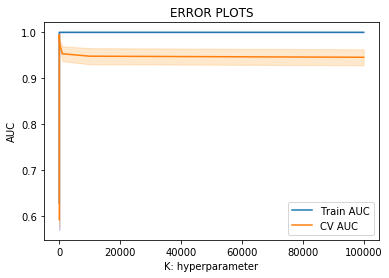

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l1', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_tfidf, y_train_tfidf)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_tfidf,y_train_tfidf))
print("Test Accuracy:",clf.score(X_test_tfidf,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 1}
AUC score on train data:  0.9999932087028377
AUC score on test data:  0.9532558045836641


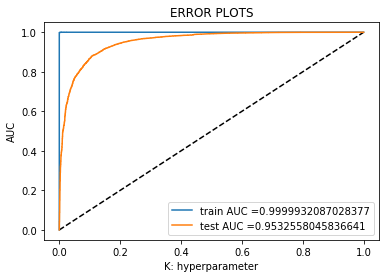

Train confusion matrix
[[67756     0]
 [  209 67547]]
Test confusion matrix
[[ 2481   970]
 [  525 16024]]


In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l1', n_jobs= -1)
LR.fit(X_train_tfidf, y_train_tfidf)

y_pred_proba_train = LR.predict_proba(X_train_tfidf)[:,1]
y_pred_proba_test = LR.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(X_test_tfidf)))

Confusion matrix for TRAIN data


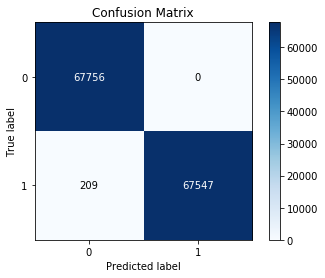

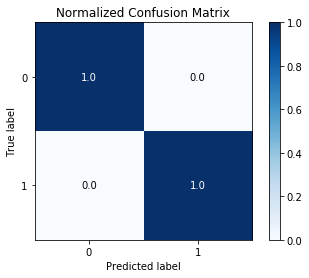

In [43]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf))
skplt.metrics.plot_confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf), normalize=True)

Confusion matrix for TEST data


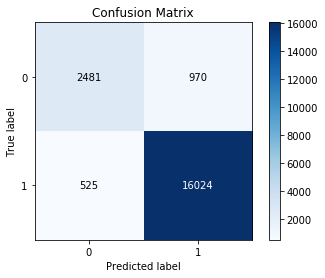

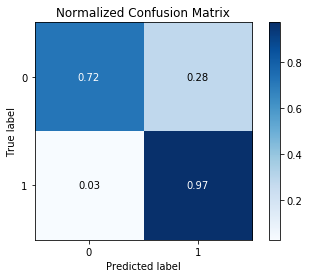

In [44]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_tfidf))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_tfidf), normalize=True)

### [4.2.2] Applying Logistic Regression with L2 regularization on TFIDF

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Training Accuracy: 0.9999909259138757
Test Accuracy: 0.9350114941011212


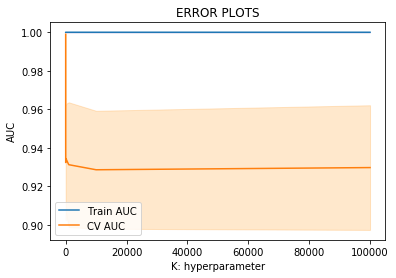

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l2', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_tfidf, y_train_tfidf)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_tfidf,y_train_tfidf))
print("Test Accuracy:",clf.score(X_test_tfidf,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.0001}
AUC score on train data:  0.9999909259138757
AUC score on test data:  0.9350114941011212


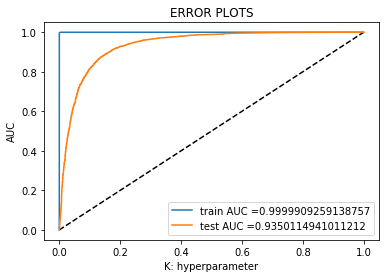

Train confusion matrix
[[67748     8]
 [  209 67547]]
Test confusion matrix
[[ 1905  1546]
 [  227 16322]]


In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LR.fit(X_train_tfidf, y_train_tfidf)

y_pred_proba_train = LR.predict_proba(X_train_tfidf)[:,1]
y_pred_proba_test = LR.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(X_test_tfidf)))

Confusion matrix for TRAIN data


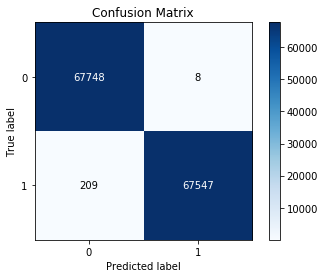

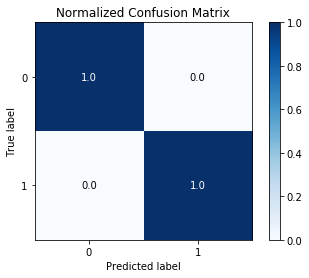

In [47]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf))
skplt.metrics.plot_confusion_matrix(y_train_tfidf, LR.predict(X_train_tfidf), normalize=True)

Confusion matrix for TEST data


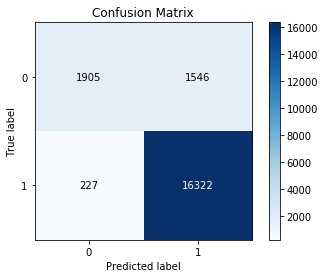

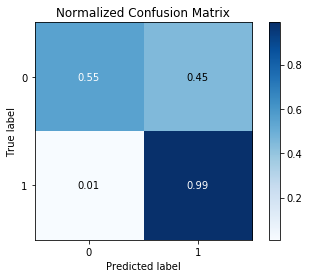

In [48]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_tfidf))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(X_test_tfidf), normalize=True)

### [4.2.3] Feature Importance on TFIDF

In [49]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(tf_idf_vect, LR)

The informative features are below: 
	-0.0328	not buy        			0.0734	great          
	-0.0310	worst          			0.0542	good           
	-0.0292	waste money    			0.0504	best           
	-0.0286	not recommend  			0.0464	love           
	-0.0277	not worth      			0.0412	delicious      
	-0.0276	disappointed   			0.0334	favorite       
	-0.0272	would not      			0.0333	find           
	-0.0265	waste          			0.0324	perfect        
	-0.0262	terrible       			0.0321	excellent      
	-0.0257	not good       			0.0315	loves          


### [4.2.4] Performing pertubation test (multicollinearity check) on TFIDF

In [50]:
# Taking 50k points from our dataset

X_train_tfidf_50k = X_train_tfidf[:50000,:10000]
y_train_tfidf_50k = y_train_tfidf[:50000]
print("The shape of X_train is: ",X_train_tfidf_50k.shape)

# Train the model with optimal C obtained from L2 reg
LReg = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LReg.fit(X_train_tfidf_50k, y_train_tfidf_50k)
weight = LReg.coef_
print("The weight vector of the model is: ",weight)

# Adding a small error to the training dataset
X_train_tfidf_M2 = (X_train_tfidf_50k.toarray()) + 0.001

The shape of X_train is:  (50000, 10000)
The weight vector of the model is:  [[0.00034111 0.         0.0038186  ... 0.00307688 0.00459526 0.        ]]


In [51]:
# Training the model with the new dataset

LReg_new = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LReg_new.fit(X_train_tfidf_M2, y_train_tfidf_50k)
weight_new = LReg_new.coef_
print("The weight vector of the new model is: ",weight_new)

The weight vector of the new model is:  [[0.00037363 0.00074458 0.00419864 ... 0.00353108 0.00503831 0.00074458]]


In [52]:
# Adding a small eps value to eliminate the divisible by zero error

weight_1 = weight + 10**-6 
weight_new_1 = weight_new + 10**-6
print("New weight values of the model: ",weight_1)
print("New weight values of new the model: ",weight_new_1)

New weight values of the model:  [[3.42108261e-04 1.00000000e-06 3.81959858e-03 ... 3.07787952e-03
  4.59625990e-03 1.00000000e-06]]
New weight values of new the model:  [[0.00037463 0.00074558 0.00419964 ... 0.00353208 0.00503931 0.00074558]]


In [54]:
# calculating the % change between weight_1 and weight_new_1

percentage_change=  (abs((weight_1-weight_new_1) / (weight_1))*100)
print("The percentage change between the two weight vectors: ",percentage_change)

# Sorting the values
percentage_change_sorted = sorted(percentage_change[0], reverse=True)

The percentage change between the two weight vectors:  [[9.50596746e+00 7.44580981e+04 9.94980852e+00 ... 1.47568711e+01
  9.63934696e+00 7.44580981e+04]]


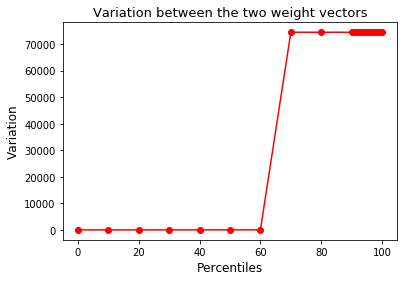

In [57]:
# Plotting the graph using elbow method

X= [0,10,20,30,40,50,60,70,80,90,91,92,93,94,95,96,97,98,99,100]

Y1 = np.percentile(percentage_change_sorted,np.arange(0, 100, 10))
Y2 = np.percentile(percentage_change_sorted,np.arange(90, 100, 1))
Y = np.concatenate((Y1,Y2))               

plt.plot(X,Y, marker='o', color='r')
plt.xlabel("Percentiles", fontsize=12)
plt.ylabel("Variation",fontsize=12)
plt.title("Variation between the two weight vectors",fontsize=13)

plt.show()


In [59]:
print("There is a sudden rise of value after 60th percentile.")
print("The 60th percentile value is: ",np.percentile(percentage_change_sorted,60))

There is a sudden rise of value after 60th percentile.
The 60th percentile value is:  22.73006474459595


## [4.3] Logistic Regression on AVG W2V

In [37]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent_train=[]
list_of_sent_test=[]
for sent in X_tr['CleanedText'].values:
    list_of_sent_train.append(sent.split())
    
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [38]:
# Train data
print(X_tr['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])
print("*****************************************************************")

# Test data
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs
*****************************************************************
['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs']
*****************************************************************
gluten free yrs tried every pasta created gluten free tinkyada hands best serve time gluten friendly friends never believe gluten free retains al dente bite holds even stored eaten later cook mine min shy lowest time recommended keep tasting cooks rinse cold water toss whatever going perfect every time
*****************************************************************
['gluten', 'free', 'yrs', 'tried', 'every', 'pasta', 'created', 'gluten', 'free', 'tinkyada', 'hands', 'best', 'serve', 'time', 'gluten', 'friendly', 'friends', 'never', 'believe', 'gluten', 'free', 'retains', 'al', 'dente', '

In [39]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)

In [40]:
w2v_words_train = list(w2v_model_train.wv.vocab)
w2v_words_test = list(w2v_model_test.wv.vocab)
print("Number of words that occured minimum 5 times in the train data: ",len(w2v_words_train))
print("Number of words that occured minimum 5 times in the test data: ",len(w2v_words_test))
print("Sample words in train data: ", w2v_words_train[0:50])

Number of words that occured minimum 5 times in the train data:  16983
Number of words that occured minimum 5 times in the test data:  8677
Sample words in train data:  ['impressed', 'triple', 'feared', 'algae', 'crosses', 'rack', 'pureed', 'soyajoy', 'verdict', 'stretching', 'sincere', 'wedges', 'dextrose', 'thanking', 'au', 'held', 'mama', 'tartar', 'choosing', 'stockpiling', 'extending', 'retail', 'smells', 'rancilio', 'solution', 'shielded', 'vault', 'trigger', 'chomp', 'ambrosoli', 'frizzy', 'biggest', 'ocean', 'durable', 'resisting', 'ticket', 'diglycerides', 'wholesale', 'monitored', 'temptation', 'ridgeback', 'accidental', 'byproducts', 'oder', 'fluff', 'instruction', 'spoken', 'raisons', 'mono', 'beaver']


In [41]:
w2v_model_train.wv.most_similar('taste')

[('flavor', 0.8500871062278748),
 ('tastes', 0.7996683120727539),
 ('aftertaste', 0.7852973341941833),
 ('tasting', 0.745978832244873),
 ('flavour', 0.7192125916481018),
 ('sounds', 0.6723398566246033),
 ('overpowering', 0.6537185907363892),
 ('hint', 0.6534652709960938),
 ('flavoring', 0.6529369354248047),
 ('gritty', 0.6150130033493042)]

In [65]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 80000/80000 [17:59<00:00, 74.14it/s] 

80000
50


In [66]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_w2v, y_train_w2v = sm.fit_resample(sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_w2v))

Resampled dataset shape Counter({0: 67756, 1: 67756})


In [67]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_w2v).items()))

Train data before upsampling:  [(0, 12244), (1, 67756)]
Train data after upsampling :  [(0, 67756), (1, 67756)]


In [68]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 20000/20000 [01:41<00:00, 197.61it/s]

20000
50


In [69]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_w2v)
standardized_data_test = StandardScaler().fit_transform(sent_vectors_test)

### [4.3.1] Applying Logistic Regression with L1 regularization on AVG W2V

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.9159942993497002
Test Accuracy: 0.8059691687001918


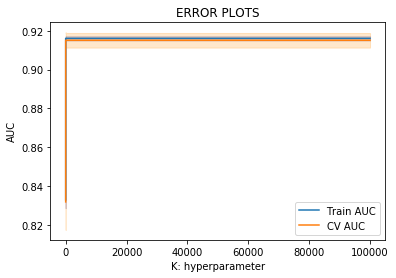

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l1', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.1}
AUC score on train data:  0.9159905915602239
AUC score on test data:  0.805827373654407


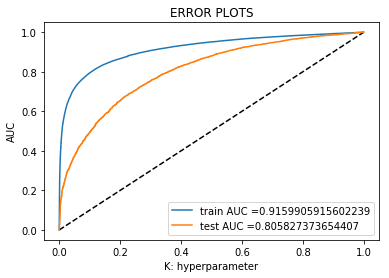

Train confusion matrix
[[59624  8132]
 [12538 55218]]
Test confusion matrix
[[ 2878   573]
 [ 6532 10017]]


In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l1', n_jobs= -1)
LR.fit(standardized_data_train, y_train_w2v)

y_pred_proba_train = LR.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = LR.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, LR.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(standardized_data_test)))

Confusion matrix for TRAIN data


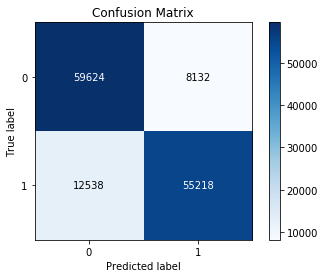

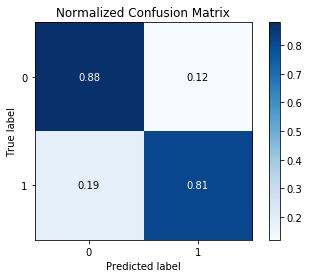

In [72]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_w2v, LR.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_w2v, LR.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


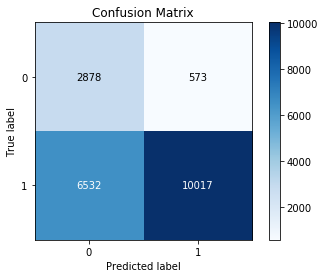

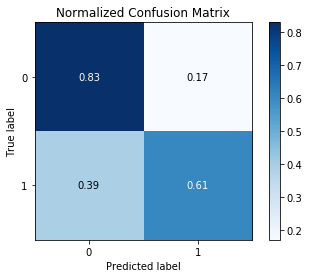

In [73]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test), normalize=True)

### [4.3.2] Applying Logistic Regression with L2 regularization on AVG W2V

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.9160005539300684
Test Accuracy: 0.8075112817499952


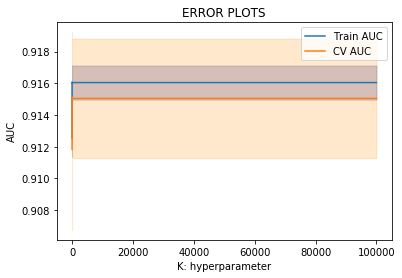

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l2', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.01}
AUC score on train data:  0.9160005539300684
AUC score on test data:  0.8075112817499952


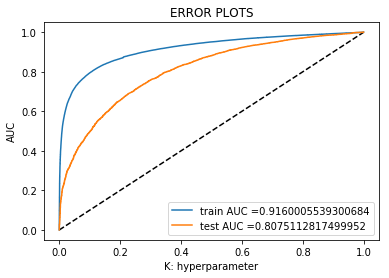

Train confusion matrix
[[59670  8086]
 [12595 55161]]
Test confusion matrix
[[ 2887   564]
 [ 6524 10025]]


In [75]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LR.fit(standardized_data_train, y_train_w2v)

y_pred_proba_train = LR.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = LR.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, LR.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(standardized_data_test)))

Confusion matrix for TRAIN data


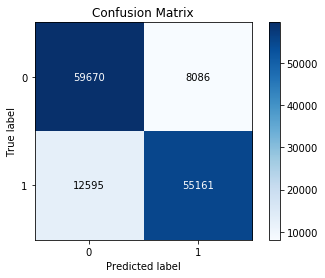

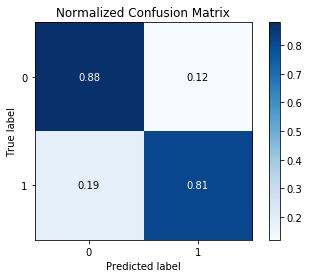

In [76]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_w2v, LR.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_w2v, LR.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


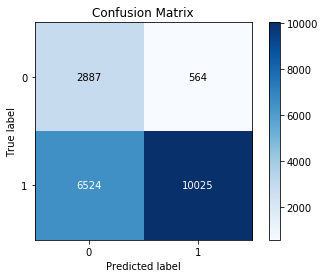

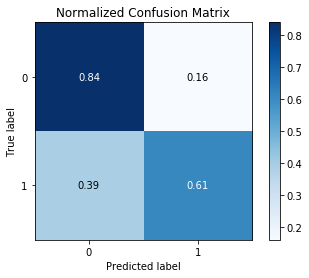

In [77]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test), normalize=True)

## [4.4] Logistic Regression on TFIDF W2V 

In [42]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_tr['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
tf_idf_matrix_test = model.transform(X_test['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_train)
            weight_sum += tf_idf_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [1:04:47<00:00, 20.58it/s]


In [45]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf_w2v, y_train_tfidf_w2v = sm.fit_resample(tfidf_sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf_w2v))

Resampled dataset shape Counter({0: 67849, 1: 67849})


In [46]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf_w2v).items()))

Train data before upsampling:  [(0, 12151), (1, 67849)]
Train data after upsampling :  [(0, 67849), (1, 67849)]


In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_test)
            weight_sum += tf_idf_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [12:29<00:00, 26.68it/s]


In [48]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_tfidf_w2v)
standardized_data_test = StandardScaler().fit_transform(tfidf_sent_vectors_test)

### [4.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V 

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.891501389470368
Test Accuracy: 0.7456099467891538


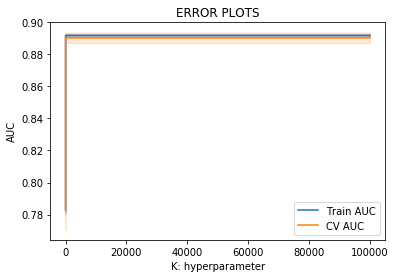

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l1', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_tfidf_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_tfidf_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.1}
AUC score on train data:  0.891501788298491
AUC score on test data:  0.7456128474001833


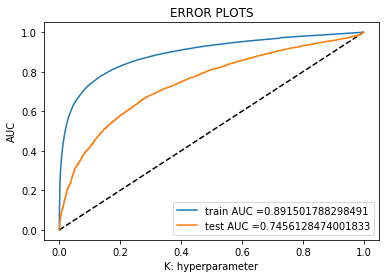

Train confusion matrix
[[57706 10143]
 [14288 53561]]
Test confusion matrix
[[2727  786]
 [6527 9960]]


In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l1', n_jobs= -1)
LR.fit(standardized_data_train, y_train_tfidf_w2v)

y_pred_proba_train = LR.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = LR.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(standardized_data_test)))

Confusion matrix for TRAIN data


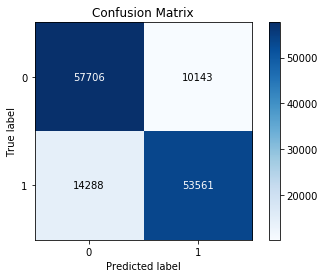

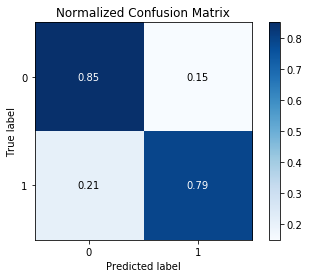

In [52]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


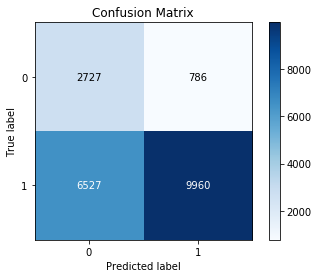

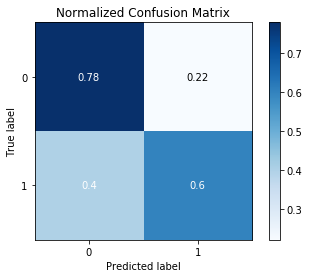

In [53]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test), normalize=True)

### [4.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Training Accuracy: 0.8915019097281865
Test Accuracy: 0.7467124034323138


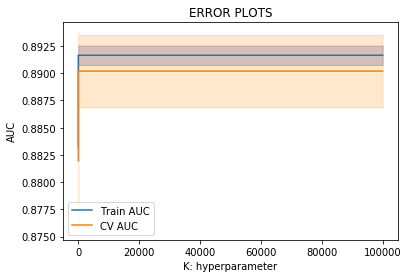

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-4,6)] 
param_grid = dict(C=k_range)

# instantiate the grid
LR = LogisticRegression(penalty= 'l2', n_jobs= -1)
clf = GridSearchCV(LR, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_tfidf_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_tfidf_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'C': 0.01}
AUC score on train data:  0.8915019097281865
AUC score on test data:  0.7467124034323138


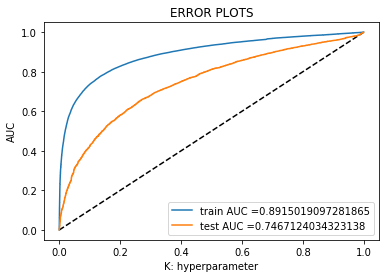

Train confusion matrix
[[57747 10102]
 [14332 53517]]
Test confusion matrix
[[2738  775]
 [6513 9974]]


In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_C = clf.best_params_.get("C")

LR = LogisticRegression(C= optimal_C, penalty= 'l2', n_jobs= -1)
LR.fit(standardized_data_train, y_train_tfidf_w2v)

y_pred_proba_train = LR.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = LR.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, LR.predict(standardized_data_test)))

Confusion matrix for TRAIN data


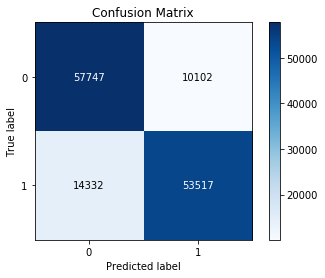

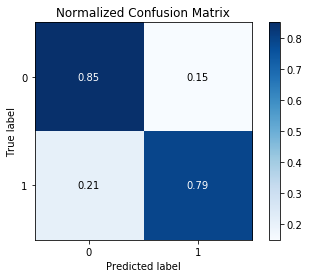

In [56]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, LR.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


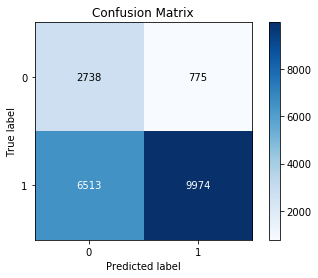

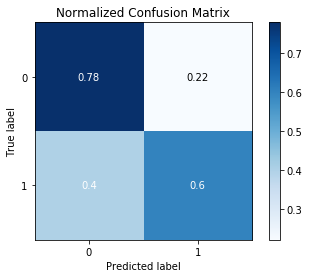

In [57]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, LR.predict(standardized_data_test), normalize=True)

# [5] Conclusions

In [58]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Regularization", "Hyper parameter", "Train AUC", "Test AUC"]

x.add_row(["BOW", "L1", 10, 0.999, 0.946])
x.add_row(["TFIDF", "L1", 1, 0.999, 0.953])
x.add_row(["W2V", "L1",0.1,0.916,0.806])
x.add_row(["TFIDFW2V", "L1",0.1,0.892,0.746 ])
x.add_row(["BOW", "L2", 0.0001, 0.999, 0.924])
x.add_row(["TFIDF", "L2",  0.0001, 0.999, 0.935])
x.add_row(["W2V", "L2",0.01,0.916,0.808 ])
x.add_row(["TFIDFW2V", "L2",0.01,0.892,0.747 ])


print(x)

+------------+----------------+-----------------+-----------+----------+
| Vectorizer | Regularization | Hyper parameter | Train AUC | Test AUC |
+------------+----------------+-----------------+-----------+----------+
|    BOW     |       L1       |        10       |   0.999   |  0.946   |
|   TFIDF    |       L1       |        1        |   0.999   |  0.953   |
|    W2V     |       L1       |       0.1       |   0.916   |  0.806   |
|  TFIDFW2V  |       L1       |       0.1       |   0.892   |  0.746   |
|    BOW     |       L2       |      0.0001     |   0.999   |  0.924   |
|   TFIDF    |       L2       |      0.0001     |   0.999   |  0.935   |
|    W2V     |       L2       |       0.01      |   0.916   |  0.808   |
|  TFIDFW2V  |       L2       |       0.01      |   0.892   |  0.747   |
+------------+----------------+-----------------+-----------+----------+
